# Лабораторная работа 1. Задача классификации

In [1]:
!pip3 install --require-virtualenv -q -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.spatial.distance import cdist
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Выборка

In [3]:
wine = load_wine(as_frame=True)

Данная выборка представляет собой результаты химического анализа содержания различных веществ в трёх
сортах вина, произведённого в одном регионе Италии тремя различными винодельческими предприятиями.
Далее будем называть эти предприятия A, B и C.

Анализ был проведён для 178 образцов вина, 59 из которых были получены от производителя A, 71 - от
производителя B, 48 - от производителя C.

Для всех вин был проведён анализ следующих 13 признаков:

- Содержание этилового спирта (alcohol)
- Содержание яблочной кислоты (malic acid)
- Количество осадок (ash)
- Щёлочность осадка (alcalinity of ash)
- Содержание магния (magnesium)
- Содержание фенолов (total phenols)
- Содержание флавоноидов (flavanoids)
- Содержание фенолов, не являющихся флавоноидами (nonflavanoid phenols)
- Содержание проантоцианидина (proanthocyanins)
- Насыщенность цвета (colour inensity)
- Оттенок (hue)
- Содержание белка (OD280/OD315 of diluted wines)
- Содержание пролина (proline)

Имеем задачу классификации на 3 класса, каждый из которых отвечает тому или иному производителю.

## 1. Анализ выборки

### 1.1. Определение типа признаков


Каждый из этих признаков является количественным.

### 1.2. Визуальный анализ данных

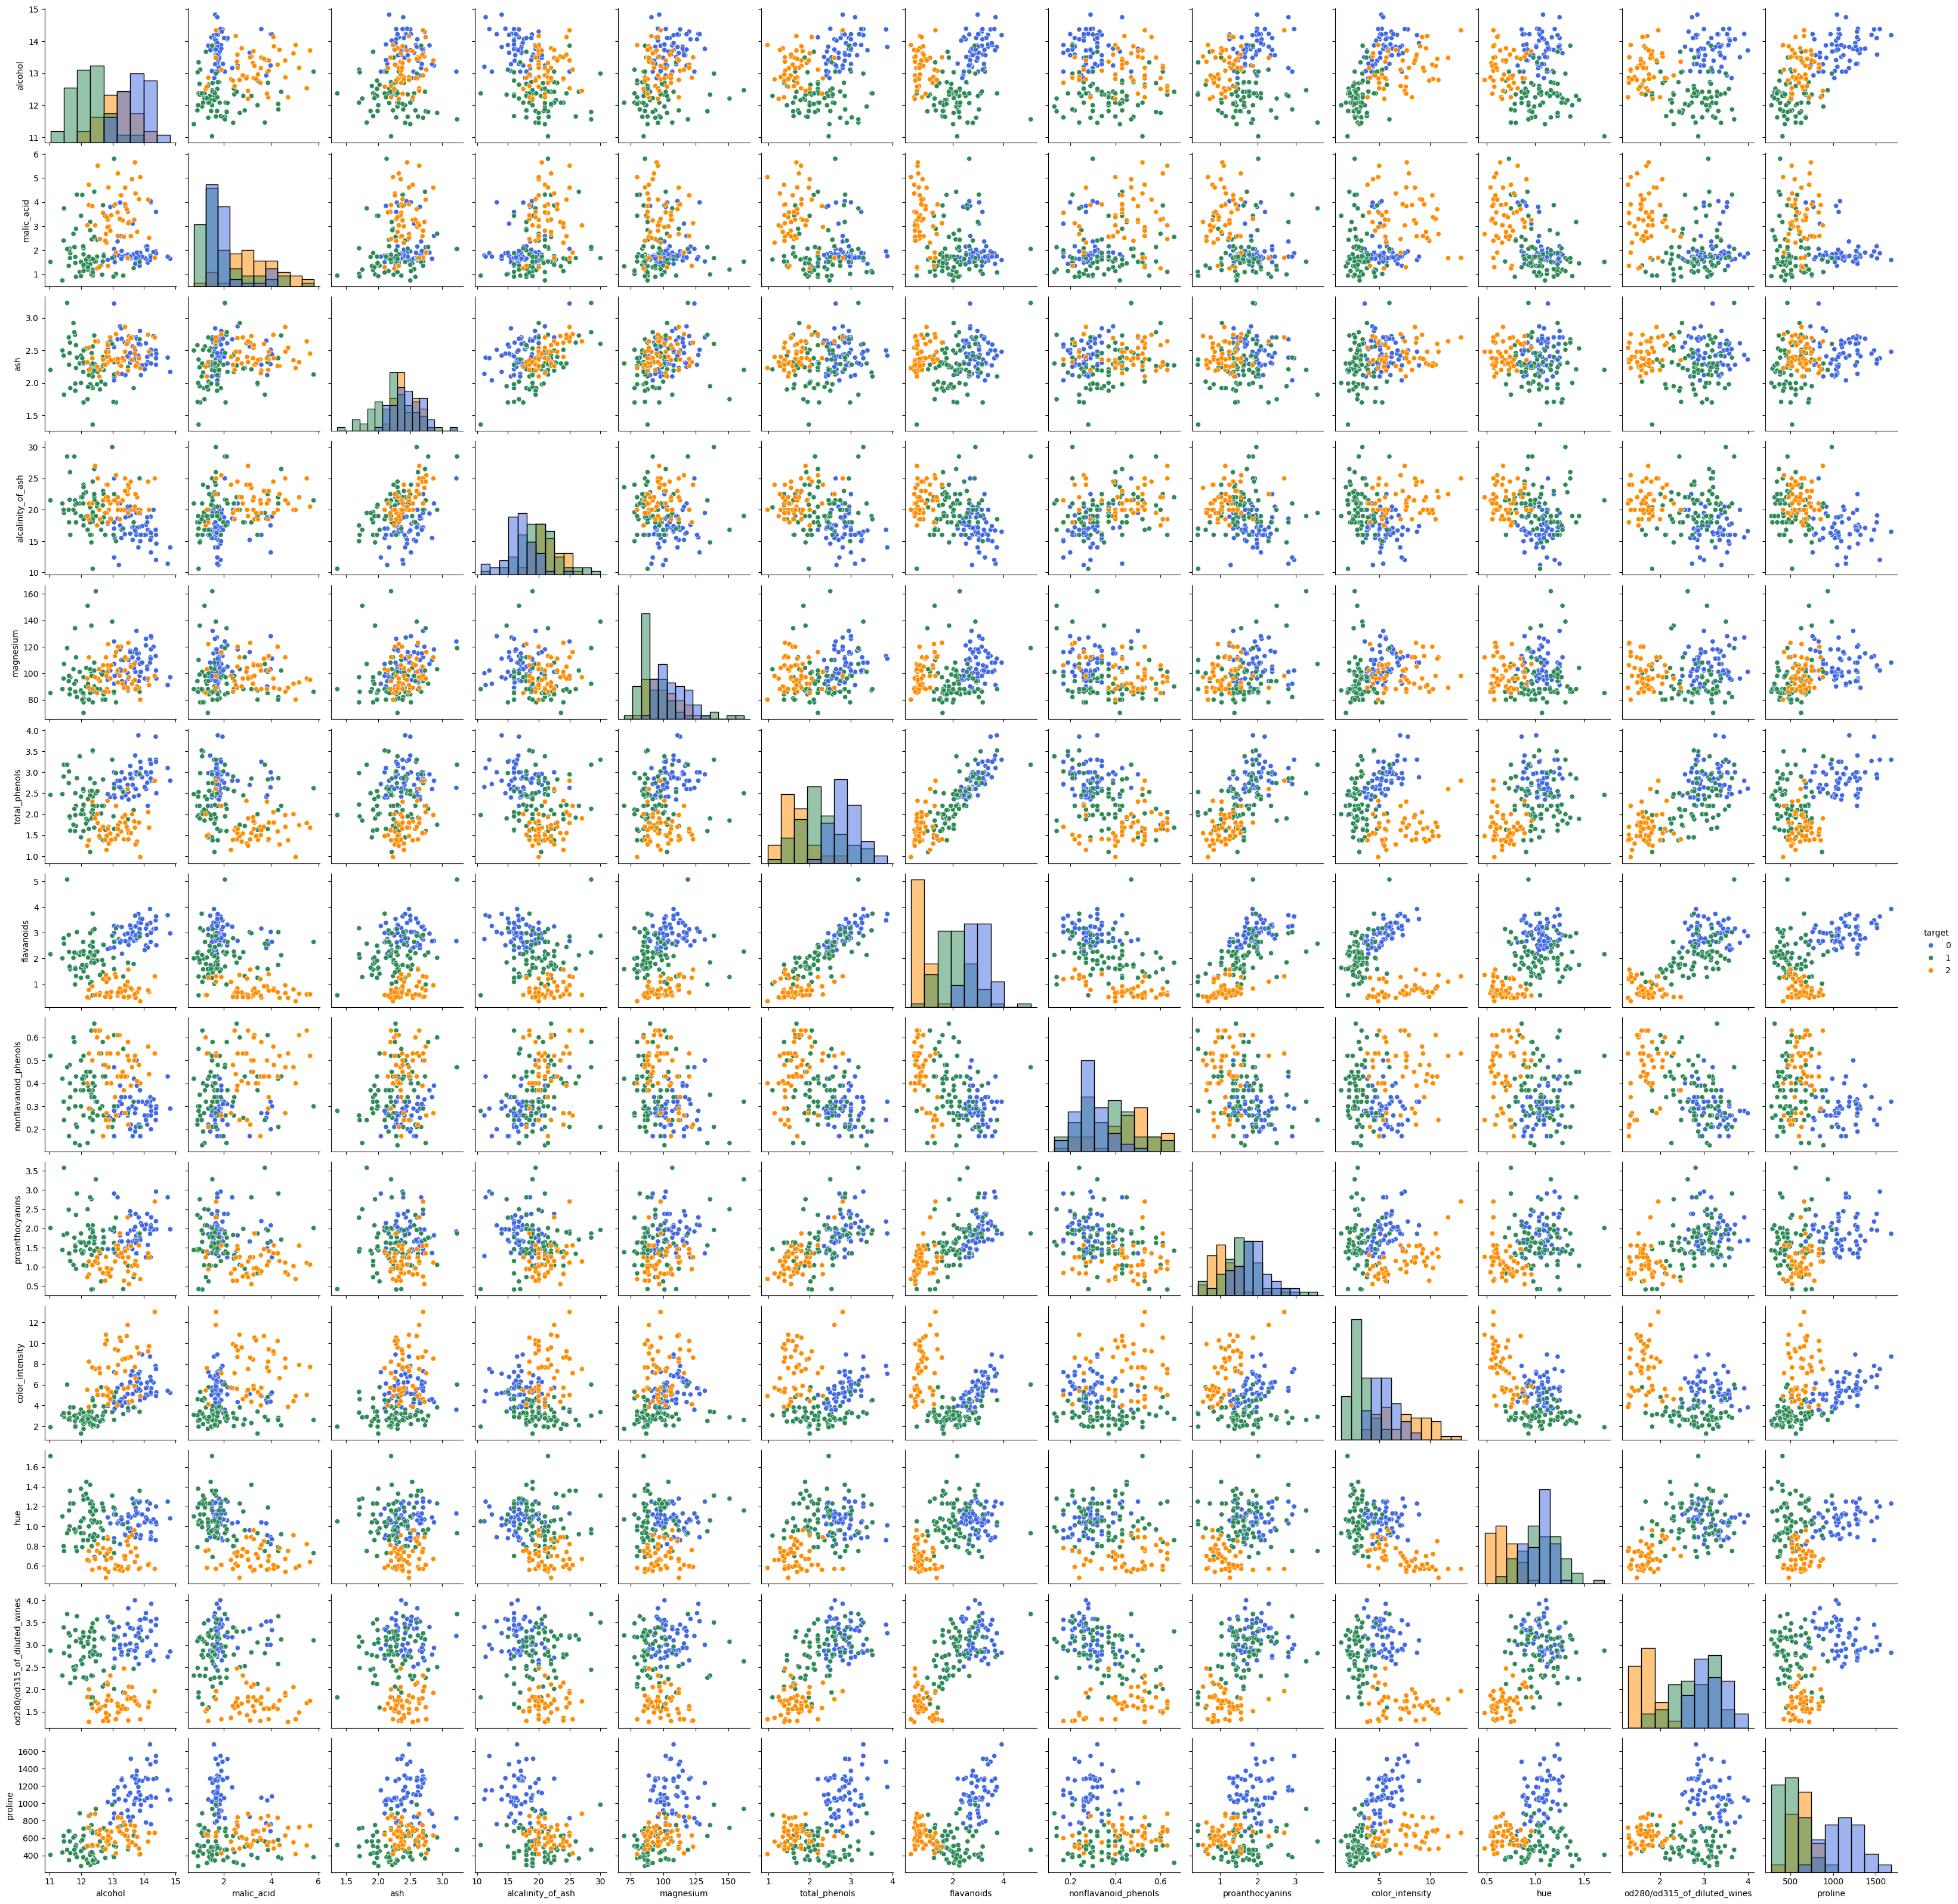

In [4]:
_ = seaborn.pairplot(data=wine.frame, hue="target", palette=["royalblue", "seagreen", "darkorange"],\
                     diag_kind="hist")

Из графиков можно извлечь, что существуют пары признаков, по которым 3 класса различимы относительно
просто. Таковыми являются, например, "alcohol + hue" и "color_intensity + flavanoids". Однако
имеются и пары признаков, по которым различить классы визуально не представляется возможным.
Таковыми являются, например, "ash + magnesium" и "alcalinity_of_ash + magnesium".

## 2. Препроцессинг данных

### 2.1. Преобразование категориальных признаков в количественные

Поскольку все признаки являются количественными, нет необходимости преобразовывать их к другому типу
признаков.

### 2.2. Разделение выборки на объекты и ответы

In [5]:
y = wine.frame.target
X = wine.frame.drop("target", axis=1)

### 2.3. Нормировка признаков

In [6]:
X = StandardScaler().fit_transform(X)

### 2.4. Разделение выборки на train и test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Эксперимент для предложенных моделей

В качестве моделей автору было предложено использовать метод потенциальных функций, перцептрон и
метод опорных векторов (SVM).

### 3.1. Метод потенциальных функций

Модель в данном методе описывается следующим выражением:
\begin{equation*}
    a(x) = \text{arg} \max\limits_{y \in Y}
        \sum\limits_{i = 1}^{l} [y_i = y] K\left(\frac{\rho(x, x_i)}{h_i}\right),
\end{equation*}
где $X^l = (x_i, y_i)_{i = 1}^{l}$ -- обучающая выборка, Y -- конечное множество ответов;
$\gamma_i \geq 0$, $h_i > 0$.

#### Подбор гиперпараметров

Данный метод предполагает два набора параметров: $\gamma_i$ и $h_i$. Параметры $h_i$ подбираются для
каждого объекта эмпирически, параметры $\gamma_i$ находятся в ходе обучения.

Таким образом, $h_i$ являются гиперпараметрами.

Для упрощения решения положим $\forall i \in \{1, \ldots, l\} \hookrightarrow h_i = h$.
Варьированием $h$ получим несколько моделей, а затем выберем лучшую.

#### Аналогия из электростатики


$\gamma_i$ -- величина заряда в точке $x_i$;

$h_i$ -- радиус действия потенциала с центром в точке $x_i$;

$y_i$ -- знак заряда для двухклассовой классификации, цвет заряда для многоклассовой классификации;

$K(r) = \dfrac{1}{1 + r}$ (добавили 1 для предотвращения деления на 0).

#### Алгоритм обучения

- Инициализируем все $\gamma_i = 0$.
- Повторять:

    - Выбрать очередную пару $(x_i, y_i) \in X^l$.
    - Если $a(x_i) \neq y_i$, то $\gamma_i = \gamma_i + 1$

- Пока процесс не сойдётся.

#### Реализация модели

In [13]:
class PotentialFunctions:

    def __init__(self, h):
        self.X = None
        self.Y = None
        self.gamma = None
        self.h = h

    def __K(self, r):
        return 1 / (1 + r)

    def predict(self, X):
        w = (self.gamma * self.__K(cdist(X, self.X) / self.h)).T
        scores = []
        for y in np.unique_values(self.Y):
            scores.append(np.sum(w[np.where(self.Y==y)[0]], axis=0))
        return np.argmax(np.vstack(scores), axis=0)

    def fit(self, X, Y, epoch=10):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.gamma = np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gamma[i] += 1

#### Применение модели

In [14]:
H = list(np.linspace(0.01, 10.0, 100))

accuracy = []
for h in H:
    model = PotentialFunctions(h)
    model.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

n = 5
print(f"Top {n} candidates for parameter h with corresponding accuracies:")
for h, acc in sorted(zip(H, accuracy), key=lambda pair : pair[1], reverse=True)[:n]:
    print(f"h: {h:.2f}; accuracy: {acc}")

Top 5 candidates for parameter h with corresponding accuracies:
h: 0.41; accuracy: 1.0
h: 0.51; accuracy: 1.0
h: 0.62; accuracy: 1.0
h: 0.72; accuracy: 1.0
h: 0.82; accuracy: 1.0
